# Improve/optimise CNN

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np

def euler_method(func, y0, t, params):
    num_eqns = len(y0)
    y = np.zeros((len(t), num_eqns))
    y[0] = y0
    dt = t[1] - t[0]
    for i in range(1, len(t)):
        y[i] = y[i - 1] + dt * func(t[i - 1], y[i - 1], params)
    return y

# Example function representing a system of ODEs with parameters
def system_of_odes(t, y, params):
    dydt = np.zeros_like(y)

    m1, p1, m2, p2, m3, p3 = y
    k1, k2, k3 = params #only 3 ks are parameters to infer
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dydt[0] = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dydt[1] = (b1 * m1) - (dp1 * p1)
    dydt[2] = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dydt[3] = (b2 * m2) - (dp2 * p2)
    dydt[4] = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dydt[5] = (b3 * m3)-(dp3 * p3)
    
    return dydt

# Initial conditions
true_params = torch.tensor([
    246.96291990024542, 246.96291990024542, 246.96291990024542]).unsqueeze(0)
num_timesteps = 100
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    full_tensor = torch.zeros((num_trajectories * num_timesteps)).unsqueeze(0)
    if len(parameter_set) == 1:
        for params in parameter_set:
            y = euler_method(system_of_odes, y0, t, params)
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            final_tensor = yt.unsqueeze(0).unsqueeze(-1)
            return final_tensor
    else:
        for params in parameter_set:
            y = euler_method(system_of_odes, y0, t, params)
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            true_tensor = yt.unsqueeze(0)
            full_tensor = torch.cat((full_tensor, true_tensor), dim=0)
        n_sims = full_tensor.size(0)
        output_tensor = full_tensor[1:n_sims]
        out = output_tensor.unsqueeze(-1)
        return out
    
num_dim = 3
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))
   

In [44]:
#kernel size here was actually 3

import torch
import torch.nn as nn
import torch.nn.functional as F
class SummaryNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 2D convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, padding=2)
        # Maxpool layer that reduces 32x32 image to 4x4
        self.pool = nn.MaxPool2d(kernel_size=5, stride=2)
        # Fully connected layer taking as input the 8 flattened output arrays from the maxpooling layer
        self.fc = nn.Linear(in_features= 8*38*36, out_features=25)

    def forward(self, x): #Shape needs to be (batch size, dim, w, h)
        x = x.view(-1, 1, 80, 75)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 8*38*36)
        x = F.relu(self.fc(x))
        return x

## Check dimensions, CNN1 (cpl)

In [5]:
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

In [6]:
# It should be 3, 1, 6000 ???
batch_size = 3
fourdim = simulator_wrapper(prior.sample((batch_size,)))
fourdim.shape

torch.Size([3, 6000, 1])

In [6]:
fourdim_r = fourdim.view(-1, 1, 80, 75)
fourdim_r.shape

torch.Size([3, 1, 80, 75])

In [39]:
pool = nn.MaxPool2d(kernel_size=5, stride=2)
conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, padding=2)
try0 = F.relu(conv1(fourdim_r))
try0.shape


torch.Size([3, 8, 80, 75])

In [40]:
try1 = pool(F.relu(conv1(fourdim_r)))
try1.shape

torch.Size([3, 8, 38, 36])

In [42]:
try2 = try1.view(-1, 8*38*36)
try2.shape

torch.Size([3, 10944])

In [43]:
fc = nn.Linear(in_features=8*38*36, out_features=25)
try3 = fc(try2)
try3.shape

torch.Size([3, 25])

# Try MAF with CNN1 (kernel_size 3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np

def euler_method(func, y0, t, params):
    num_eqns = len(y0)
    y = np.zeros((len(t), num_eqns))
    y[0] = y0
    dt = t[1] - t[0]
    for i in range(1, len(t)):
        y[i] = y[i - 1] + dt * func(t[i - 1], y[i - 1], params)
    return y

# Example function representing a system of ODEs with parameters
def system_of_odes(t, y, params):
    dydt = np.zeros_like(y)

    m1, p1, m2, p2, m3, p3 = y
    k1, k2, k3 = params #only 3 ks are parameters to infer
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dydt[0] = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dydt[1] = (b1 * m1) - (dp1 * p1)
    dydt[2] = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dydt[3] = (b2 * m2) - (dp2 * p2)
    dydt[4] = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dydt[5] = (b3 * m3)-(dp3 * p3)
    
    return dydt

# Initial conditions
true_params = [
    246.96291990024542, 246.96291990024542, 246.96291990024542]
num_timesteps = 1000
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    full_tensor = torch.zeros((num_trajectories * num_timesteps)).unsqueeze(0)
    if len(parameter_set) == 1:
        for params in parameter_set:
            y = euler_method(system_of_odes, y0, t, params)
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            final_tensor = yt.unsqueeze(0).unsqueeze(-1)
            return final_tensor
    else:
        for params in parameter_set:
            y = euler_method(system_of_odes, y0, t, params)
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            true_tensor = yt.unsqueeze(0)
            full_tensor = torch.cat((full_tensor, true_tensor), dim=0)
        n_sims = full_tensor.size(0)
        output_tensor = full_tensor[1:n_sims]
        out = output_tensor.unsqueeze(-1)
        return out
    
num_dim = 3
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))
true_data = simulator(torch.tensor(true_params).unsqueeze(0))

In [2]:
true_data = simulator(torch.tensor(true_params).unsqueeze(0))
true_data.shape

torch.Size([1, 6000, 1])

In [5]:
batch_size = 3
fourdim = simulator_wrapper(prior.sample((batch_size,)))
fourdim.shape

torch.Size([3, 6000, 1])

In [4]:
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

In [9]:
#Parallelise it
# PART 1: Edited code from original sbi repos. Functions edited: simulate_for_sbi, and all the functions it contains.
#Main changes: defined simulator_seeded globally rather than within simulate_in_batches function, and re-imported torch within simulator_seeded 
#NO changes need to be made in this file

# PART 2: Essentially the unparallelised code with 2 extra arguments in the simulate_for_sbi line

##################################### PART 1 #########################################
import joblib
import contextlib
import random
import torch
import numpy as np

from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm

import sbi
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os

from sbi.inference import SNLE, prepare_for_sbi
# No longer importing simulate_for_sbi from the package, we use the one defined above
from sbi import utils as utils
from sbi import analysis as analysis

def seed_all_backends(seed: Optional[Union[int, Tensor]] = None) -> None:
    if seed is None:
        seed = int(torch.randint(1_000_000, size=(1,)))
    else:
        # Cast Tensor to int (required by math.random since Python 3.11)
        seed = int(seed)

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

def simulator_seeded(simulator: Callable, theta: Tensor, seed: int) -> Tensor:
    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    with torch.random.fork_rng(devices=[]):
        torch.manual_seed(seed)
        return simulator(theta)

def simulate_in_batches(simulator: Callable, theta: Tensor, sim_batch_size: int = 1, num_workers: int = 1,
                        seed: Optional[int] = None, show_progress_bars: bool = True, ) -> Tensor:

    num_sims, *_ = theta.shape
    seed_all_backends(seed)

    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        batches = split(theta, sim_batch_size, dim=0)

        if num_workers != 1:
            batch_seeds = randint(high=1_000_000, size=(len(batches),))

            with tqdm_joblib(
                tqdm(batches, disable=not show_progress_bars,
                     desc=f"Running {num_sims} simulations in {len(batches)} batches.", total=len(batches),)) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(delayed(simulator_seeded)(simulator, batch, batch_seed)
                    for batch, batch_seed in zip(batches, batch_seeds))
        else:
            pbar = tqdm(total=num_sims, disable=not show_progress_bars, desc=f"Running {num_sims} simulations.", )

            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator_seeded(simulator, batch, seed))
                    pbar.update(sim_batch_size)

        x = cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)

    return x


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

def simulate_for_sbi(simulator: Callable, proposal: Any, num_simulations: int, num_workers: int = 1,
                     simulation_batch_size: int = 1, seed: Optional[int] = None,
                     show_progress_bar: bool = True, ) -> Tuple[Tensor, Tensor]:

    theta = proposal.sample((num_simulations,))

    x = simulate_in_batches(simulator=simulator, theta=theta, sim_batch_size=simulation_batch_size,
                            num_workers=num_workers, seed=seed, show_progress_bars=show_progress_bar,)

    return theta, x

######################################################################################################

simulation_batch_size = 200
num_simulations = 1200

# To parallelise, set number of CPUs to be used. Note: parallelise anything that has num_rounds>2 and/or num_simulations>50
# to see total available CPUs: print(os.cpu_count())

CPUs_to_use = 8

total_CPUs = os.cpu_count()
num_workers = CPUs_to_use - total_CPUs -1
# num_workers = -1 uses all cpus
# num_workers = -2 uses all cpus but one etc https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html
if CPUs_to_use > total_CPUs:
    raise ValueError(f"Cannot use more CPUs than are available. Available CPUs: {total_CPUs}")

In [27]:
num_rounds = 2
#Reset embedding net?
embedding_net_custom = SummaryNet()

simulator_wrapper, prior = prepare_for_sbi(simulator, prior)


# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net_custom, hidden_features=25, num_transforms=2)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

num_simulations = 1000
simulation_batch_size = 150

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

Running 1000 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


 Neural network successfully converged after 168 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 84 epochs.

In [28]:
#Is it actually an MCMC posterior?
proposal

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

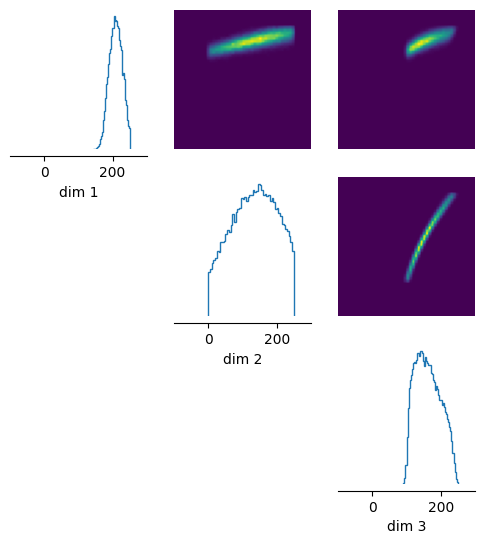

In [29]:
posterior_samples = posterior.sample((50000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

## Preserve temporal relationships of the data... cannot just choose an arbitrary shape?

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SummaryNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 2D convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=2)
        # Maxpool layer that reduces 32x32 image to 4x4
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1)
        # Fully connected layer taking as input the 8 flattened output arrays from the maxpooling layer
        self.fc = nn.Linear(in_features= 8*6*1000, out_features=25)

    def forward(self, x): #Shape needs to be (batch size, dim, w, h)
        x = x.view(-1, 1, 6, 1000)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 8*6*1000)
        x = self.fc(x)
        return x

In [6]:
# It should be 3, 1, 6000 ???
batch_size = 3
fourdim = simulator_wrapper(prior.sample((batch_size,)))
fourdim.shape

torch.Size([3, 6000, 1])

In [7]:
fourdim_r = fourdim.view(-1, 1, 6,1000)
fourdim_r.shape

torch.Size([3, 1, 6, 1000])

In [10]:
pool = nn.MaxPool2d(kernel_size=3, stride=1)
conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
try0 = F.relu(conv1(fourdim_r))
try0.shape


torch.Size([3, 8, 6, 1000])

In [11]:
try1 = pool(F.relu(conv1(fourdim_r)))
try1.shape

torch.Size([3, 8, 4, 998])

In [12]:
try2 = try1.view(-1, 8*4*998)
try2.shape

torch.Size([3, 31936])

In [13]:
fc = nn.Linear(in_features=8*4*998, out_features=25)
try3 = fc(try2)
try3.shape

torch.Size([3, 25])

In [10]:
## Try to preserve the relationships of the data with the same kernel size of 3...

num_rounds = 2
#Reset embedding net?
embedding_net_custom = SummaryNet()

simulator_wrapper, prior = prepare_for_sbi(simulator, prior)


# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net_custom, hidden_features=25, num_transforms=2)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

num_simulations = 1000
simulation_batch_size = 150

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

posterior_samples = posterior.sample((5000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

Running 1000 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


 Training neural network. Epochs trained: 8

KeyboardInterrupt: 

In [60]:
posterior

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

In [62]:
posterior_samples.shape

torch.Size([50000, 3])

# Try CNN2 (cplll)

In [11]:
fourdim_r = fourdim.view(-1, 1, 6, 1000) # 3(batch)x1x80x75
pool = nn.MaxPool2d(kernel_size=3, stride=1)
conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
try0 = F.relu(conv1(fourdim_r))
try0.shape

torch.Size([3, 8, 6, 1000])

In [12]:
try1 = pool(F.relu(conv1(fourdim_r)))
try1.shape

torch.Size([3, 8, 4, 998])

In [13]:
try2 = try1.view(-1, 8*4*998)
try2.shape

torch.Size([3, 31936])

In [14]:
fc1 = nn.Linear(in_features=8*4*998, out_features=4096)
fc2 = nn.Linear(in_features=4096, out_features=1024)
fc3 = nn.Linear(in_features=1024, out_features=25)
try3 = fc1(try2)
try3.shape

torch.Size([3, 4096])

In [15]:
try4 = fc2(try3)
try4.shape

torch.Size([3, 1024])

In [16]:
try5 = fc3(try4)
try5.shape

torch.Size([3, 25])

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SummaryNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 2D convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        # Maxpool layer that reduces 32x32 image to 4x4
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1) ###STRIDE = 2
        # Fully connected layer taking as input the 8 flattened output arrays from the maxpooling layer
        self.fc1 = nn.Linear(in_features=8*4*998, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=25)

    def forward(self, x): #Shape needs to be (batch size, dim, w, h)
        x = x.view(-1, 1, 6,1000)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 8 *2*499)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [24]:
#Parallelise it
# PART 1: Edited code from original sbi repos. Functions edited: simulate_for_sbi, and all the functions it contains.
#Main changes: defined simulator_seeded globally rather than within simulate_in_batches function, and re-imported torch within simulator_seeded 
#NO changes need to be made in this file

# PART 2: Essentially the unparallelised code with 2 extra arguments in the simulate_for_sbi line

##################################### PART 1 #########################################
import joblib
import contextlib
import random
import torch
import numpy as np

from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm

import sbi
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os

from sbi.inference import SNLE, prepare_for_sbi
# No longer importing simulate_for_sbi from the package, we use the one defined above
from sbi import utils as utils
from sbi import analysis as analysis

def seed_all_backends(seed: Optional[Union[int, Tensor]] = None) -> None:
    if seed is None:
        seed = int(torch.randint(1_000_000, size=(1,)))
    else:
        # Cast Tensor to int (required by math.random since Python 3.11)
        seed = int(seed)

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

def simulator_seeded(simulator: Callable, theta: Tensor, seed: int) -> Tensor:
    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    with torch.random.fork_rng(devices=[]):
        torch.manual_seed(seed)
        return simulator(theta)

def simulate_in_batches(simulator: Callable, theta: Tensor, sim_batch_size: int = 1, num_workers: int = 1,
                        seed: Optional[int] = None, show_progress_bars: bool = True, ) -> Tensor:

    num_sims, *_ = theta.shape
    seed_all_backends(seed)

    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        batches = split(theta, sim_batch_size, dim=0)

        if num_workers != 1:
            batch_seeds = randint(high=1_000_000, size=(len(batches),))

            with tqdm_joblib(
                tqdm(batches, disable=not show_progress_bars,
                     desc=f"Running {num_sims} simulations in {len(batches)} batches.", total=len(batches),)) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(delayed(simulator_seeded)(simulator, batch, batch_seed)
                    for batch, batch_seed in zip(batches, batch_seeds))
        else:
            pbar = tqdm(total=num_sims, disable=not show_progress_bars, desc=f"Running {num_sims} simulations.", )

            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator_seeded(simulator, batch, seed))
                    pbar.update(sim_batch_size)

        x = cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)

    return x


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

def simulate_for_sbi(simulator: Callable, proposal: Any, num_simulations: int, num_workers: int = 1,
                     simulation_batch_size: int = 1, seed: Optional[int] = None,
                     show_progress_bar: bool = True, ) -> Tuple[Tensor, Tensor]:

    theta = proposal.sample((num_simulations,))

    x = simulate_in_batches(simulator=simulator, theta=theta, sim_batch_size=simulation_batch_size,
                            num_workers=num_workers, seed=seed, show_progress_bars=show_progress_bar,)

    return theta, x

######################################################################################################

simulation_batch_size = 200
num_simulations = 1200

# To parallelise, set number of CPUs to be used. Note: parallelise anything that has num_rounds>2 and/or num_simulations>50
# to see total available CPUs: print(os.cpu_count())

CPUs_to_use = 8

total_CPUs = os.cpu_count()
num_workers = CPUs_to_use - total_CPUs -1
# num_workers = -1 uses all cpus
# num_workers = -2 uses all cpus but one etc https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html
if CPUs_to_use > total_CPUs:
    raise ValueError(f"Cannot use more CPUs than are available. Available CPUs: {total_CPUs}")

Running 1000 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

 Neural network successfully converged after 151 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 49 epochs.

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

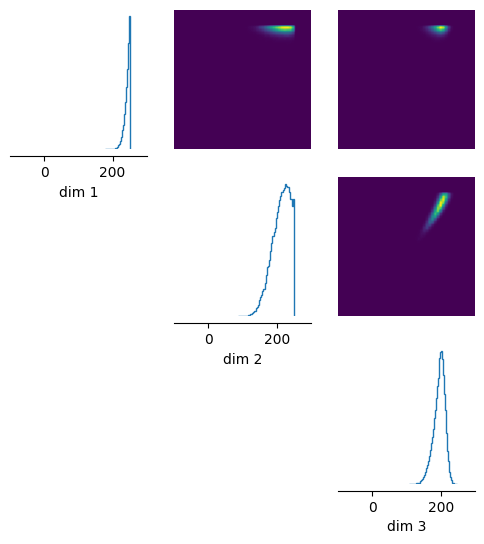

In [37]:
## Try to preserve the relationships of the data with the same kernel size of 3...

num_rounds = 2
#Reset embedding net?
embedding_net_custom = SummaryNet()

simulator_wrapper, prior = prepare_for_sbi(simulator, prior)


# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net_custom, hidden_features=25, num_transforms=2)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

num_simulations = 1000
simulation_batch_size = 150

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

posterior_samples = posterior.sample((50000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

In [ ]:
# Seaborn plots
import seaborn as sns
 

column_name = ['k1','k2','k3']

snre_flattened_pos = pd.DataFrame(data=posterior_samples,columns=column_name)
#snre_ss_pos = pd.DataFrame(data=posterior_samples_sre, columns=column_name)

snre_flattened_pos['type']="flattened trajectories"
#snre_ss_pos["type"]="summary statistics"
df_joint = pd.concat([snre_flattened_pos, snre_ss_pos])
g=sns.PairGrid(df_joint, diag_sharey=False, hue="type")
g.map_diag(sns.kdeplot, fill=True, alpha=0.2)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot,s=3)
g.add_legend()
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, 1))

# Try CNN3 (cpcplll)

In [28]:
fourdim_r = fourdim.view(-1, 1, 6,1000) # 3(batch)x1x80x75
pool = nn.MaxPool2d(kernel_size=3, stride=1)
conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
try0 = F.relu(conv1(fourdim_r))
try0.shape

torch.Size([3, 8, 6, 1000])

In [29]:
try1 = pool(F.relu(conv1(fourdim_r)))
try1.shape

torch.Size([3, 8, 4, 998])

In [30]:
try1_5 = pool(F.relu(conv2(try1)))
try1_5.shape

torch.Size([3, 16, 2, 996])

In [32]:
try2 = try1_5.view(-1, 16*2*996)
try2.shape

torch.Size([3, 31872])

In [33]:
fc1 = nn.Linear(in_features=16*2*996, out_features=1024)
fc2 = nn.Linear(in_features=1024, out_features=25)
try3 = fc1(try2)
try3.shape

torch.Size([3, 1024])

In [35]:
try4 = fc2(try3)
try4.shape

torch.Size([3, 25])

In [23]:
#Simulator
###### Simulate
headers = ["k1" , "k2", "k3"]          # parameters to be inferred
num_timesteps = 100

# FOR SNLE
prior_min = 0.01                        # same for all parameters
prior_max = 250    

t = np.linspace(0, 100, num_timesteps)

param_dict = {'k1': 246.96291990024542, 'k2': 246.96291990024542, 'k3': 246.96291990024542, 'n1': 5, 'n2': 5, 'n3': 5, 'dm1': 1.143402097500176, 'dm2': 1.143402097500176, 'dm3': 1.143402097500176, 'dp1': 0.7833664565550977, 'dp2': 0.7833664565550977, 'dp3': 0.7833664565550977,
              'a1': 24.78485282457379, 'a2': 24.78485282457379, 'a3': 24.78485282457379, 'g1': 0.024884149937163258, 'g2': 0.024884149937163258, 'g3': 0.024884149937163258, 'b1': 33.82307682700831, 'b2': 33.82307682700831, 'b3': 33.82307682700831}

all_params = 'a1', 'a2', 'a3', 'g1', 'g2', 'g3', 'dm1', 'dm2', 'dm3', 'dp1', 'dp2', 'dp3', 'b1', 'b2', 'b3', 'n1', 'n2', 'n3', 'k1', 'k2', 'k3'
new_param_dict ={}
for param in all_params:
    if param not in headers:
        new_param_dict[param] = param_dict[param]
    elif param in headers:
        new_param_dict[param] = param

def my_simulator(theta):
    def model(variables, t, theta, new_param_dict = new_param_dict):
        m1, p1, m2, p2, m3, p3 = variables
        for i in range(len(headers)):
            new_param_dict[headers[i]] = theta[i]
        
        dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
        dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
        dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
        dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
        dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
        dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)

        return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

    def solve_ode(theta, t):
        initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
        y = odeint(model, initial_conditions, t, args=(theta,))
        yt = torch.tensor(y, dtype=torch.float32).T.flatten()
        return yt.unsqueeze(-1)
    return solve_ode(theta, t)
prior = utils.BoxUniform(
    low=torch.tensor([10**-2,10**-2,10**-2]),
    high=torch.tensor([250.,250.,250.]))
true_params = tuple(param_dict[parameter] for parameter in headers)
true_data = my_simulator(true_params)
num_dim = len(true_params)
simulator_wrapper, prior = prepare_for_sbi(my_simulator, prior)

batch_size = 3
fourdim = simulator_wrapper(prior.sample((batch_size,)))
fourdim.shape

torch.Size([3, 600, 1])

In [22]:
fourdim_r = fourdim.view(-1, 1, 6, 100)
pool = nn.MaxPool2d(kernel_size=3, stride=1)
conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=2)
conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=2)
try0 = F.relu(conv1(fourdim_r))
try0.shape


torch.Size([3, 8, 8, 102])

In [24]:
try1 = pool(F.relu(conv1(fourdim_r)))
try1.shape

torch.Size([3, 8, 6, 100])

In [25]:
try2 = pool(F.relu(conv2(try1)))
try2.shape

torch.Size([3, 16, 6, 100])

In [ ]:
fc = nn.Linear(in_features=8*4*98, out_features=25)
try3 = fc(try2)
try3.shape

torch.Size([3, 25])

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SummaryNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 2D convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        # Maxpool layer that reduces 32x32 image to 4x4
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1)
        # Fully connected layer taking as input the 8 flattened output arrays from the maxpooling layer
        self.fc1 = nn.Linear(in_features=16*2*996, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=1024)
        self.fc3 = nn.Linear(in_features=1024, out_features=25)

    def forward(self, x): #Shape needs to be (batch size, dim, w, h)
        x = x.view(-1, 1, 6, 1000)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*2*996)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

Running 1000 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

 Neural network successfully converged after 93 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 63 epochs.

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

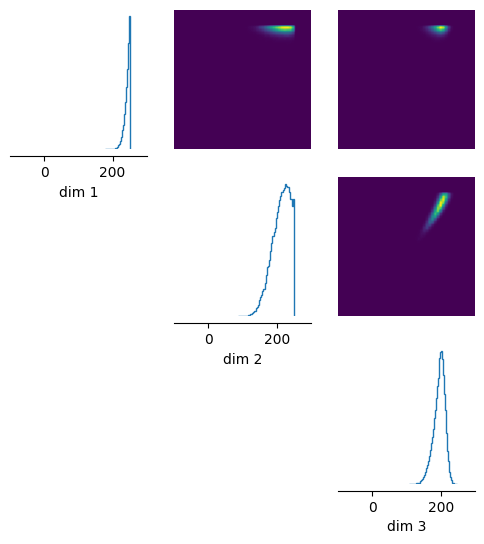

In [43]:
num_rounds = 2
#Reset embedding net?
embedding_net_custom = SummaryNet()

simulator_wrapper, prior = prepare_for_sbi(simulator, prior)


# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net_custom, hidden_features=25, num_transforms=2)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

num_simulations = 1000
simulation_batch_size = 150

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

posterior_samples_cpcp = posterior.sample((50000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

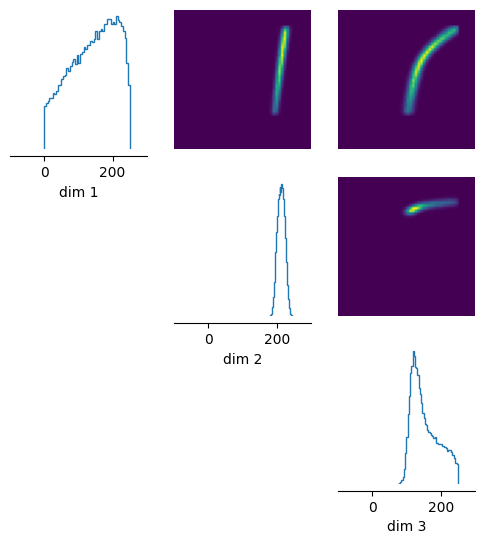

In [44]:
_ = analysis.pairplot(
    posterior_samples_cpcp, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

In [53]:
embedding_net_devices = [p.device for p in embedding_net_custom.parameters()]
print("Embedding net devices output:")
embedding_net_devices

Embedding net devices output [device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]


In [49]:
toy_datum = simulator_wrapper(torch.tensor(true_params).unsqueeze(0))
toy_datum2 = simulator_wrapper(torch.tensor([200,200,200]).unsqueeze(0))

In [51]:
def check_data_device(datum_1: torch.Tensor, datum_2: torch.Tensor) -> None:
    """Checks if two tensors have the seme device. Fails if there is a device
    discrepancy

    Args:
        datum_1: torch `Tensor`
        datum_2: torch `Tensor`
    """
    assert datum_1.device == datum_2.device, (
        "Mismatch in fed data's device: "
        f"datum_1 has device '{datum_1.device}' whereas "
        f"datum_2 has device '{datum_2.device}'. Please "
        "use data from a common device."
    )
check_data_device(toy_datum, toy_datum2)

In [52]:
toy_datum.device

device(type='cpu')